# CAB420 DCNNs, Bonus Example: Calibrating Neural Networks
Dr Simon Denman (s.denman@qut.edu.au)

### What is a "Bonus" Example?

These are extra examples that cover content outside the scope of CAB420. It exists becuase of one or more of the following reasons:
* It's closely related to other stuff we're looking at and I wanted to include it, but the course has too much content already, so I punted it here; 
* It's interesting;
* Someone (probably multiple someones if I wrote an example) has asked a question about it before.

You can freely ignore this example if you want. You really don't have to be reading this. You could go outside, go read a book, have a nap, take up a hobby, whatever you want really. The point I want to make here **this example really is optional**. Things here won't appear on an exam, or in an assignment (though you could use this in an assignment if you wanted). But if you're interested, this is here, and if you're reading this, so are you. 

Some things to note with bonus examples:
* These may gloss over details that elsewhere get more coverage. I may skip plots I'd normally include, or gloss over other details. The expecatation is that if you're reading this, you've looked at all the "core" examples and are comfortable with what they're doing. 
* Some bits of code might not be as well explained or explored as you're used to in the other examples. These examples are here for interested students looking to extend their knowledge, and I'm assuming if you're here, you're comfortable figuring code out, debugging stuff, and generally googling about to help work out what something is doing.
* There's no Tl;DR section at the top. If you're here, I'm assuming it's because you're interested and want all the gory details and don't just need the quick summary at the top.
* While my regular examples (the "core" ones) certainly contain their fare share of silly remarks and typos, expect the level of flippancy and the prevalence of typos increase in a bonus example. 

That said, as always, if you are stuggling to follow what I've got in here please shoot me a message. The aim is still for this to be clear enough to follow afterall.

## Overview

If they were a person, a typical DCNN would probably be characterised as an arrogant bastard. They are the professional athletets of the machine learning world: highly tuned, high performing beasts, that are incredibly confident in their own ability. 

What I'm getting at with this ill-conceived analogy is that neural networks are often very confident in their decisions. A typical model trained for classification will output some softmax scores. If we get say a score of 0.8 for a given class, we might assume that this indicates that there is an 80% chance that the true value will be this class, i.e. 20% of the time our network will be wrong. In practice, this is rarely the case and networks are often massivley over-confident, i.e. they are wrong more often than they should be if the softmax scores were actually probabilities.

One way to address this is to calibrate the model. Essentially, this amounts to applying a weight to the softmax scores after the network has been trained, such that soft-max scores are now better calibrated 

### Where does this fit into all the other CAB420 content?

This really fits alongside the other DCNN content, and can be seen as an extension of this content. We're also fleshing out the idea of a model ensemble a bit more here, and some of the ideas in here also relate to the Bayesian DCNNs bonus example.

In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import datetime
import numpy as np

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorboard import notebook

import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

import seaborn as sns

### Functions, Functions and More Functions

We're going to need to some functions to help us out. These have all be taken from [here](https://github.com/hollance/reliability-diagrams).

There's two main functions here that are worth talking about:
* `compute_calibration`: What we want, is a model that's *well calibrated*. In the context of this example, this means that we want the softmax score to behave like a likelihood, i.e. for 5 samples where the softmax score is ~0.5, the model should right 5 times. To compute this we'll quantise the confidence into a number of bins (default 10) and look at how often the model is correct in each of those. In other words, we'll find all the samples where the softmax score is, for example, in the range 0.8-0.9, and we'll look at how often the model is correct in those instances. We'll also compute a score, the *expected calibration error*, that tells us how far out the model is.
* `reliability_diagram`: This will draw a diagram that will show how well calibrated our model is. There are a few other functions in there to support this. 

I'm not going to dive deep into the code here. I didn't write it, and it's not that hard to follow - but really the concepts are the more important thing in this example.

In [2]:
def compute_calibration(true_labels, pred_labels, confidences, num_bins=10):
    """Collects predictions into bins used to draw a reliability diagram.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
    The true_labels, pred_labels, confidences arguments must be NumPy arrays;
    pred_labels and true_labels may contain numeric or string labels.
    For a multi-class model, the predicted label and confidence should be those
    of the highest scoring class.
    Returns a dictionary containing the following NumPy arrays:
        accuracies: the average accuracy for each bin
        confidences: the average confidence for each bin
        counts: the number of examples in each bin
        bins: the confidence thresholds for each bin
        avg_accuracy: the accuracy over the entire test set
        avg_confidence: the average confidence over the entire test set
        expected_calibration_error: a weighted average of all calibration gaps
        max_calibration_error: the largest calibration gap across all bins
    """
    assert(len(confidences) == len(pred_labels))
    assert(len(confidences) == len(true_labels))
    assert(num_bins > 0)

    bin_size = 1.0 / num_bins
    bins = np.linspace(0.0, 1.0, num_bins + 1)
    indices = np.digitize(confidences, bins, right=True)

    bin_accuracies = np.zeros(num_bins, dtype=float)
    bin_confidences = np.zeros(num_bins, dtype=float)
    bin_counts = np.zeros(num_bins, dtype=int)

    for b in range(num_bins):
        selected = np.where(indices == b + 1)[0]
        if len(selected) > 0:
            bin_accuracies[b] = np.mean(true_labels[selected] == pred_labels[selected])
            bin_confidences[b] = np.mean(confidences[selected])
            bin_counts[b] = len(selected)

    avg_acc = np.sum(bin_accuracies * bin_counts) / np.sum(bin_counts)
    avg_conf = np.sum(bin_confidences * bin_counts) / np.sum(bin_counts)

    gaps = np.abs(bin_accuracies - bin_confidences)
    ece = np.sum(gaps * bin_counts) / np.sum(bin_counts)
    mce = np.max(gaps)

    return { "accuracies": bin_accuracies, 
             "confidences": bin_confidences, 
             "counts": bin_counts, 
             "bins": bins,
             "avg_accuracy": avg_acc,
             "avg_confidence": avg_conf,
             "expected_calibration_error": ece,
             "max_calibration_error": mce }


def _reliability_diagram_subplot(ax, bin_data, 
                                 draw_ece=True, 
                                 draw_bin_importance=False,
                                 title="Reliability Diagram", 
                                 xlabel="Confidence", 
                                 ylabel="Expected Accuracy"):
    """Draws a reliability diagram into a subplot."""
    accuracies = bin_data["accuracies"]
    confidences = bin_data["confidences"]
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    widths = bin_size
    alphas = 0.3
    min_count = np.min(counts)
    max_count = np.max(counts)
    normalized_counts = (counts - min_count) / (max_count - min_count)

    if draw_bin_importance == "alpha":
        alphas = 0.2 + 0.8*normalized_counts
    elif draw_bin_importance == "width":
        widths = 0.1*bin_size + 0.9*bin_size*normalized_counts

    colors = np.zeros((len(counts), 4))
    colors[:, 0] = 240 / 255.
    colors[:, 1] = 60 / 255.
    colors[:, 2] = 60 / 255.
    colors[:, 3] = alphas

    gap_plt = ax.bar(positions, np.abs(accuracies - confidences), 
                     bottom=np.minimum(accuracies, confidences), width=widths,
                     edgecolor=colors, color=colors, linewidth=1, label="Gap")

    acc_plt = ax.bar(positions, 0, bottom=accuracies, width=widths,
                     edgecolor="black", color="black", alpha=1.0, linewidth=3,
                     label="Accuracy")

    ax.set_aspect("equal")
    ax.plot([0,1], [0,1], linestyle = "--", color="gray")
    
    if draw_ece:
        ece = (bin_data["expected_calibration_error"] * 100)
        ax.text(0.98, 0.02, "ECE=%.2f" % ece, color="black", 
                ha="right", va="bottom", transform=ax.transAxes)

    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    #ax.set_xticks(bins)

    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    ax.legend(handles=[gap_plt, acc_plt])


def _confidence_histogram_subplot(ax, bin_data, 
                                  draw_averages=True,
                                  title="Examples per bin", 
                                  xlabel="Confidence",
                                  ylabel="Count"):
    """Draws a confidence histogram into a subplot."""
    counts = bin_data["counts"]
    bins = bin_data["bins"]

    bin_size = 1.0 / len(counts)
    positions = bins[:-1] + bin_size/2.0

    ax.bar(positions, counts, width=bin_size * 0.9)
   
    ax.set_xlim(0, 1)
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)

    if draw_averages:
        acc_plt = ax.axvline(x=bin_data["avg_accuracy"], ls="solid", lw=3, 
                             c="black", label="Accuracy")
        conf_plt = ax.axvline(x=bin_data["avg_confidence"], ls="dotted", lw=3, 
                              c="#444", label="Avg. confidence")
        ax.legend(handles=[acc_plt, conf_plt])


def _reliability_diagram_combined(bin_data, 
                                  draw_ece, draw_bin_importance, draw_averages, 
                                  title, figsize, dpi, return_fig):
    """Draws a reliability diagram and confidence histogram using the output
    from compute_calibration()."""
    figsize = (figsize[0], figsize[0] * 1.4)

    fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=figsize, dpi=dpi, 
                           gridspec_kw={"height_ratios": [4, 1]})

    plt.tight_layout()
    plt.subplots_adjust(hspace=-0.1)

    _reliability_diagram_subplot(ax[0], bin_data, draw_ece, draw_bin_importance, 
                                 title=title, xlabel="")

    # Draw the confidence histogram upside down.
    orig_counts = bin_data["counts"]
    bin_data["counts"] = -bin_data["counts"]
    _confidence_histogram_subplot(ax[1], bin_data, draw_averages, title="")
    bin_data["counts"] = orig_counts

    # Also negate the ticks for the upside-down histogram.
    new_ticks = np.abs(ax[1].get_yticks()).astype(int)
    ax[1].set_yticklabels(new_ticks)    

    plt.show()

    if return_fig: return fig


def reliability_diagram(true_labels, pred_labels, confidences, num_bins=10,
                        draw_ece=True, draw_bin_importance=False, 
                        draw_averages=True, title="Reliability Diagram", 
                        figsize=(6, 6), dpi=72, return_fig=False):
    """Draws a reliability diagram and confidence histogram in a single plot.
    
    First, the model's predictions are divided up into bins based on their
    confidence scores.
    The reliability diagram shows the gap between average accuracy and average 
    confidence in each bin. These are the red bars.
    The black line is the accuracy, the other end of the bar is the confidence.
    Ideally, there is no gap and the black line is on the dotted diagonal.
    In that case, the model is properly calibrated and we can interpret the
    confidence scores as probabilities.
    The confidence histogram visualizes how many examples are in each bin. 
    This is useful for judging how much each bin contributes to the calibration
    error.
    The confidence histogram also shows the overall accuracy and confidence. 
    The closer these two lines are together, the better the calibration.
    
    The ECE or Expected Calibration Error is a summary statistic that gives the
    difference in expectation between confidence and accuracy. In other words,
    it's a weighted average of the gaps across all bins. A lower ECE is better.
    Arguments:
        true_labels: the true labels for the test examples
        pred_labels: the predicted labels for the test examples
        confidences: the predicted confidences for the test examples
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        draw_averages: whether to draw the overall accuracy and confidence in
            the confidence histogram
        title: optional title for the plot
        figsize: setting for matplotlib; height is ignored
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    bin_data = compute_calibration(true_labels, pred_labels, confidences, num_bins)
    return _reliability_diagram_combined(bin_data, draw_ece, draw_bin_importance,
                                         draw_averages, title, figsize=figsize, 
                                         dpi=dpi, return_fig=return_fig)


def reliability_diagrams(results, num_bins=10,
                         draw_ece=True, draw_bin_importance=False, 
                         num_cols=4, dpi=72, return_fig=False):
    """Draws reliability diagrams for one or more models.
    
    Arguments:
        results: dictionary where the key is the model name and the value is
            a dictionary containing the true labels, predicated labels, and
            confidences for this model
        num_bins: number of bins
        draw_ece: whether to include the Expected Calibration Error
        draw_bin_importance: whether to represent how much each bin contributes
            to the total accuracy: False, "alpha", "widths"
        num_cols: how wide to make the plot
        dpi: setting for matplotlib
        return_fig: if True, returns the matplotlib Figure object
    """
    ncols = num_cols
    nrows = (len(results) + ncols - 1) // ncols
    figsize = (ncols * 4, nrows * 4)

    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, 
                           figsize=figsize, dpi=dpi, constrained_layout=True)

    for i, (plot_name, data) in enumerate(results.items()):
        y_true = data["true_labels"]
        y_pred = data["pred_labels"]
        y_conf = data["confidences"]
        
        bin_data = compute_calibration(y_true, y_pred, y_conf, num_bins)
        
        row = i // ncols
        col = i % ncols
        _reliability_diagram_subplot(ax[row, col], bin_data, draw_ece, 
                                     draw_bin_importance, 
                                     title="\n".join(plot_name.split()),
                                     xlabel="Confidence" if row == nrows - 1 else "",
                                     ylabel="Expected Accuracy" if col == 0 else "")

    for i in range(i + 1, nrows * ncols):
        row = i // ncols
        col = i % ncols        
        ax[row, col].axis("off")
        
    plt.show()

    if return_fig: return 

### Fashion MNIST

We're sticking with fashion MNIST. Nothing surprising here. We'll do the regulation load, split the training set into training and validation, and then do a sanity check on the data size.

In [3]:
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=4)

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1) / 255
y_train = y_train.reshape(y_train.shape[0], 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1) / 255
y_val = y_val.reshape(y_val.shape[0], 1)
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1) / 255
y_test = y_test.reshape(y_test.shape[0], 1)

print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)

(48000, 28, 28, 1)
(48000, 1)
(12000, 28, 28, 1)
(12000, 1)
(10000, 28, 28, 1)
(10000, 1)


### A Simple Network

Massive networks are not the name of the game here - so we'll just create a very simple network. That said, you'll see similar nonsense with very complex network, so the things we're going to do here do apply elsewhere.

**IMPORTANT DETAIL ALERT**: The below looks like a regular old simple fashion mnist model, and it is. But for reasons that are not yet obvious I got the logits as their own named layer, with the softmax applied afterwards. This is important, as I need those logits later on in this example.

In [4]:
def simple_fmnist_cnn():
    inputs = keras.Input(shape=(28, 28, 1, ), name='img')

    x = layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu')(inputs)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2, 2))(x)
    x = layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu')(x)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Flatten()(x)
    logits = layers.Dense(10, activation=None, name='logits')(x)
    outputs = layers.Activation('softmax')(logits)

    model_cnn = keras.Model(inputs=inputs, outputs=outputs, name='fashion_mnist_cnn_model')
    return model_cnn

I'm going to train 10 models here. We'll look at both the calibration performance of a single model, and of an ensemble. This is the other reason for the simple model defined above. I want to train 10 of them, and I don't want to have to wait too long while writing this.

In [5]:
models = []
histories = []
num_models = 10
epochs = 40
batch_size = 64

for i in range(num_models):

    print('Training model %d/%d' % (i + 1, num_models))
    m = simple_fmnist_cnn()
    m.compile(loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False), 
               optimizer=keras.optimizers.Adam(),
               metrics=['accuracy'])
    h = m.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_val, y_val), verbose=False)
    
    models.append(m)
    histories.append(h)

Training model 1/10
Training model 2/10
Training model 3/10
Training model 4/10
Training model 5/10
Training model 6/10
Training model 7/10
Training model 8/10
Training model 9/10
Training model 10/10


Models are trained, time to make some predictions. We'll pull out predictions for each of the 10 models.

In [6]:
preds = []
indexes = []
for i in range(num_models):
    p = models[i].predict(x_test, verbose=False)
    idx = np.argmax(p, axis = 1)
    preds.append(p)
    indexes.append(idx)

And then we'll get an average. This gives us the results of our ensemble. We'll just average the softmax scores across the 10, and then take the argmax of those.

Note that there are otherways that we could combine these models. The one you're most likely to see would be using a concensus approach. In this, we'll look at the final prediction of each of the 10 models, and take a vote. For example, We might have 5 models that say class 0, 2 models for class 4, and 3 models for class 7. In this case, class 0 has the most votes, so we'd take that one. With the voting approach, it is possible that the class with the highest average softmax score is not actually selected as the final class.

In [7]:
average_prediction = np.mean(np.asarray(preds), axis = 0)
average_idx = np.argmax(average_prediction, axis = 1)

Performance wise, anyone who's looked at any of the other Fashion MNIST example knows what to expect here. About 90% performnace, and a slight performance boost on the ensemble model. This isn't why we're here - but it's good to confirm our models are working as we expect.

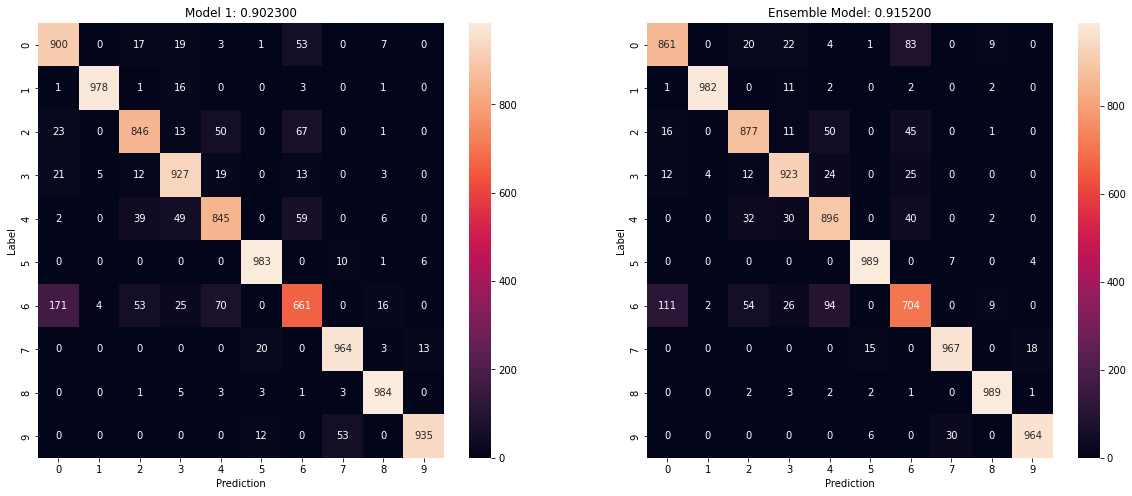

In [8]:
confusion_mtx = tf.math.confusion_matrix(y_test, indexes[0]) 
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Model 1: %f' % (sum(indexes[0] == y_test[:,0]) / len(y_test)))

confusion_mtx = tf.math.confusion_matrix(y_test, average_idx) 
ax = fig.add_subplot(1, 2, 2)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Ensemble Model: %f' % (sum(average_idx == y_test[:,0]) / len(y_test)));

### Measuring Calibration Accuracy

This is the main event. We plot that on first glance, is probably very confusing. It may also be very confusing on the second, third, and forth glances. Let's try to break it down.

Focus on the large top plot first. In this:
* The diagonal dashed line is the expected results for a perfectly calibrated model. This is what we're comparing to.
* We have divided the confidence scores into 10 bins, so we see 10 groups of a black horizontal line, and a shaded red patch as we move from left to right. Consider the group second from the right, in the $0.8-0.9$ range. The black bar is what we recorded in terms of accuracy for this group. So for samples that have a softmax score between $0.8-0.9$, the mode is right ~75% of the time. Looking at the third group from the right ($0.7-0.8$) we see similar behaviour. Our accuracy there is ~65%. The shaded red area is the difference between what we expect (for a perfectly calibrated model) and what we observe. Ideally, we'd see no red areas.
* The *Expected Calibration Error* is given in the bottom right of the plot. This can be seen as something like the sum of all the red bars. A smaller number is better here.

Now for the bottom plot:
* The bars are a histogram, showing how many samples we have in each confidence bin. We can see that the vast majority of samples are in the $0.9-1.0$ bin.
* The solid vertical black line shows the overall accuracy (~90%), and the dashed vertical line shows the average confidence. A perfectly calibrated model will have these lines on top of each other.

I mentioned above that DCNNs are overconfident. We can see this in these plots in a couple of places:
* Looking at the red bars on the top plot, we see that for many bins the reported accuracy lies below the expected. Thinking about the $0.8-0.9$ bin again, we expect the accuracy here to ~85%, but we observe ~75%. The model is overconfident with it's softmax scores in this range as it is wrong more often than it should be.
* Looking at the solid and dashed vertical line on the bottom plot, we see that the average confidence is higher than the average accuracy, suggesting that there are a number cases where our model is nice and confident of something, and is then wrong.

/tmp/ipykernel_8706/354891260.py:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


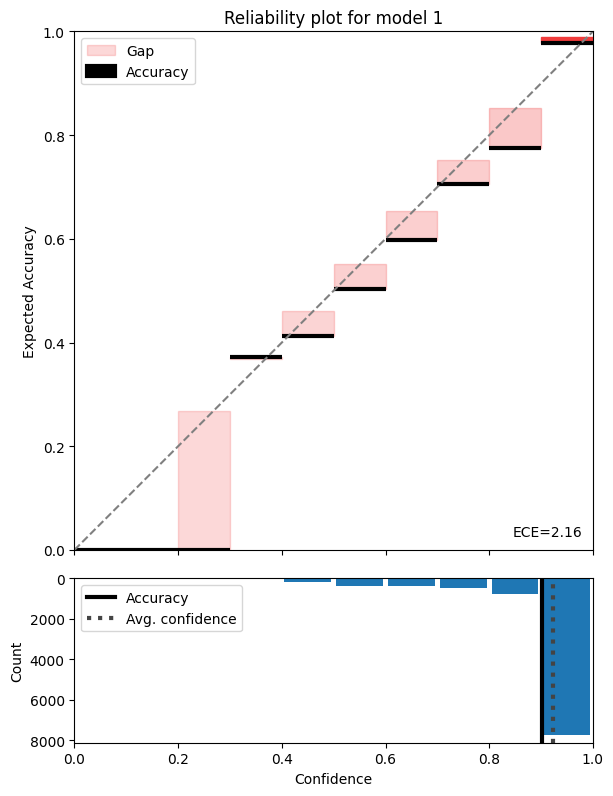

In [9]:
fig = reliability_diagram(np.reshape(y_test, -1), 
                          np.argmax(preds[0], axis=1), np.max(preds[0], axis=1), 
                          num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title='Reliability plot for model 1', figsize=(6, 6), dpi=100, 
                          return_fig=True)

All of this discussion and the problem that are being highlighted don't mean that the model is broken, or failed, or some such thing. This should hopefully just highlight that our softmax scores really aren't probabilities. Though, it'd be really great if they were more like probabilities.

With that in mind, let's look at the ensemble model and see how well it fares in the calibration stakes.

/tmp/ipykernel_8706/354891260.py:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


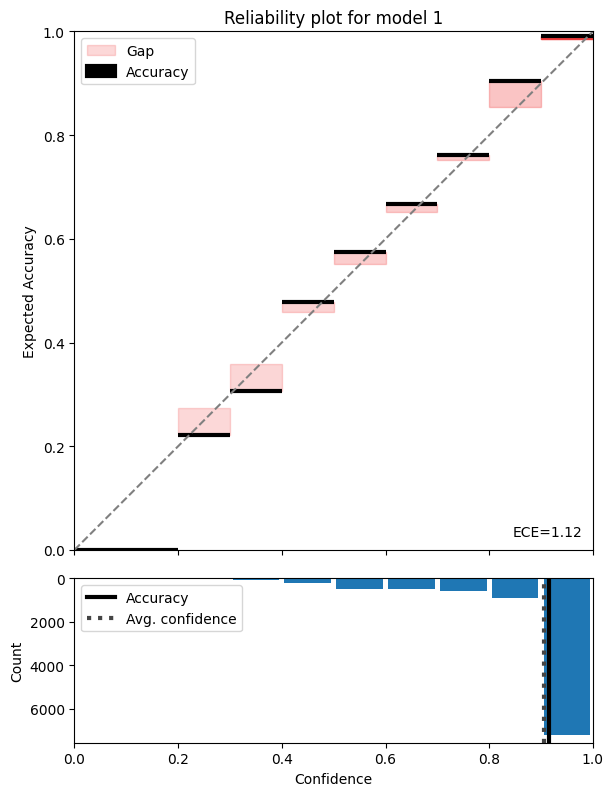

In [10]:
fig = reliability_diagram(np.reshape(y_test, -1), 
                          np.argmax(average_prediction, axis=1), np.max(average_prediction, axis=1), 
                          num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title='Reliability plot for model 1', figsize=(6, 6), dpi=100, 
                          return_fig=True)

Our expected calibration error has gone down quite a bit, and if anything our model is now underconfident (consider the bottom plot, the average confidence now lies to the left of the accuracy). We see a mix of bins being under and over confident, while with the single model we saw most being overconfident.

Ensembles are one way to get a more meaningful estimate of the likelihood, or an estimate of uncertainty. However, there are other ways.

### Calibrating your Model

What we want is to apply some sort of transform to our softmax scores to get them to look and feel a bit more like likelihoods. In particular, there 

We can learn a transform to do this. We will use temperature scaling (in particlar, a form of this called Platt scaling) to attempt to calibrate our logits, such that when they are then passed through a softmax they behave a bit more like probabilities. This scaling operation looks like this:

$P(\hat{y}) = \frac{e^{\frac{z}{T}}}{\sum_j e^{\frac{x_j}{T}}}$

where:
* $\hat{y}$ is the prediction
* $z$ is the logits, and $z_j$ is a single logit
* $T$ is scaling parameter, which we need to learn

I've borrowed some code from [here](https://github.com/cerlymarco/MEDIUM_NoteBook/blob/master/NeuralNet_Calibration/NeuralNet_Calibration.ipynb) to learn this parameter $T$ for us.

In [11]:
def fit_TemperatureCalibration(train_X_y, valid_X_y=None, epochs=100):
    
    ### inspired by: https://github.com/stellargraph/stellargraph/blob/develop/stellargraph/calibration.py ###
    
    T = tf.Variable(tf.ones(shape=(1,)))
    history = []
    early_stopping = False
    optimizer = keras.optimizers.Adam(learning_rate=0.001)
    
    def cost(T, x, y):

        scaled_logits = tf.multiply(x=x, y=1.0 / T)

        cost_value = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits(logits=scaled_logits, labels=y)
        )

        return cost_value

    def grad(T, x, y):

        with tf.GradientTape() as tape:
            cost_value = cost(T, x, y)

        return cost_value, tape.gradient(cost_value, T)
    
    
    X_train, y_train = train_X_y
    if valid_X_y:
        X_valid, y_valid = valid_X_y
        early_stopping = True
    
    
    for epoch in range(epochs):
        train_cost, grads = grad(T, X_train, y_train)
        optimizer.apply_gradients(zip([grads], [T]))
        if early_stopping:
            val_cost = cost(T, X_valid, y_valid)
            if (len(history) > 0) and (val_cost > history[-1][1]):
                break
            else: 
                history.append([train_cost, val_cost, T.numpy()[0]])
        else:
            history.append([train_cost, T.numpy()[0]])

    history = np.asarray(history)
    temperature = history[-1, -1]
    
    return temperature


def calibrated_proba(logits, temperature):
    
    scaled_prediction = logits / temperature

    return np.exp(scaled_prediction) / np.sum(np.exp(scaled_prediction), axis=-1, keepdims=True)

To set this up, we need to pull the logits from our already trained model. This is where naming that layer earlier comes in as we can now create a model that simply skips the final soft max activation.

Using this model, we can get some predictions (i.e. pull out the logits) and then use this to train our temperature calibration.

In [12]:
# create model that doesn't contain the final softmax
model_score = keras.Model(models[0].input, models[0].get_layer('logits').output)

# predict for both the validation and test sets. Here we'll use
# - the validation set to train the temperature calibration
# - the test set as a validation set for this training
# Yes, I know the naming here get's confusing. Sorry.
x_val_calib = model_score.predict(x_val, verbose=False)
x_test_calib = model_score.predict(x_test, verbose=False)

# Get the temperature prediction
temperature = fit_TemperatureCalibration((x_val_calib, y_val), (x_test_calib, y_test), epochs=100)
print(temperature)

1.0968217


Now we can use our temperature scaling to hopefully improve the calibration of our model. First up, let's see if the models accuracy has been impacted at all.

Text(0.5, 1.0, 'Model 1: 0.902300')

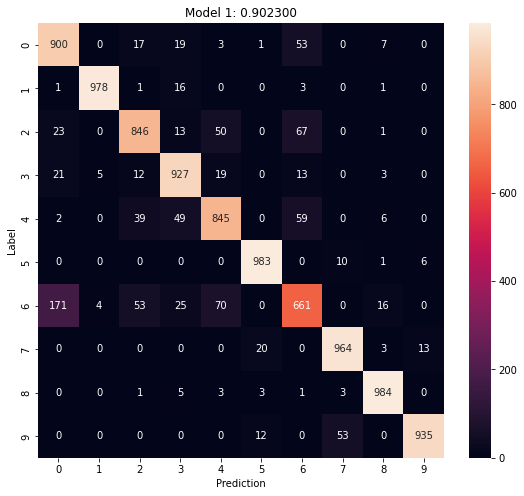

In [13]:
# get test logits
X_test_logits = model_score.predict(x_test, verbose=False)
# apply temperature scaling using learned temperature
X_test_calib = calibrated_proba(X_test_logits, temperature)

#plot results
confusion_mtx = tf.math.confusion_matrix(y_test, np.argmax(X_test_calib, axis=1)) 
fig = plt.figure(figsize=(20, 8))
ax = fig.add_subplot(1, 2, 1)
sns.heatmap(confusion_mtx, annot=True, fmt='g')
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
ax.set_title('Model 1: %f' % (sum(np.argmax(X_test_calib, axis=1) == y_test[:,0]) / len(y_test)))
# profit?

No. But this is what we expect. If we compare this confusion matrix to the one from the first model prior to calibration, it is identical. We haven't changed our network at all, we just scaled the logits. Whatever class was most likely before is still most likely now, we've (hopefully) just scale the softmax scores so they behave a bit more like how we want them to.

/tmp/ipykernel_8706/354891260.py:168: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(new_ticks)


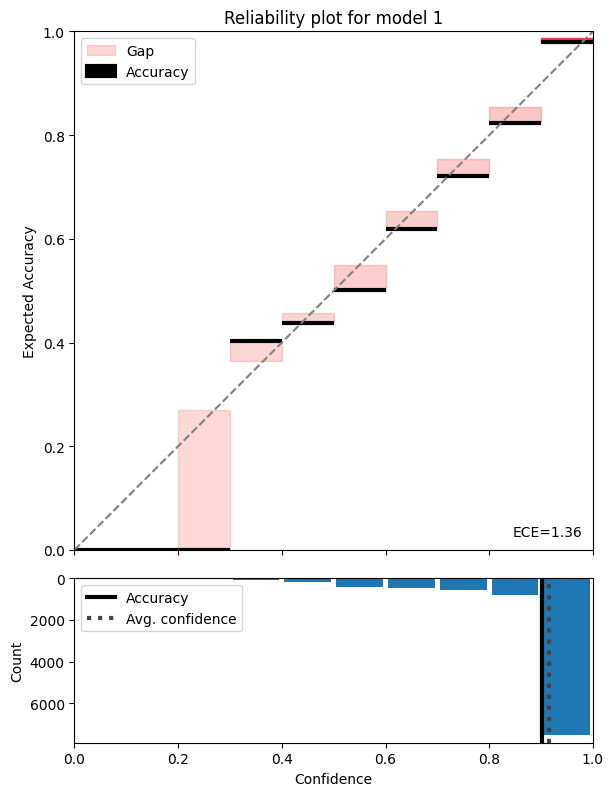

In [14]:
fig = reliability_diagram(np.reshape(y_test, -1), 
                          np.argmax(X_test_calib, axis=1), np.max(X_test_calib, axis=1), 
                          num_bins=10, draw_ece=True,
                          draw_bin_importance="alpha", draw_averages=True,
                          title='Reliability plot for model 1', figsize=(6, 6), dpi=100, 
                          return_fig=True)

And from the calibration plot we can see that we have. We've reduced our estimated calibration error quite a bit, and have a bit of a mix of under and over confident bins. The model is not perfect, but it's behaving a bit more like how it should and we're certainly closer to being able to treat our softmax scores as likelihoods, or at the very least be aware of the kind of problems we may be making for ourselves if we do.